In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
from config import settings
from src.data import datamodule as dm
from pathlib import Path
from src.model.transformation import (FromBuffer , 
                                      CutPSD, LogTransform , NormLayer , SqueezeLayer,
                                      UnsqueezeLayer)


import matplotlib.pyplot as plt
from torch import nn 
from src.data.utils import print_database_overview, load_all_from_db 


In [59]:
db_path = Path(settings.path.processed, 'norther.db')
assert db_path.exists(), f"Database not found at {db_path}"
print_database_overview(db_path)
meta_data = load_all_from_db(db_path, 'metadata')
frequency_axis = FromBuffer()(meta_data.loc[0,'frequency_axis'])

SQLite Database Overview
Table: processed_data - id, timestamp, turbine_name, Welch_X, Welch_Y, Welch_Z, RMS_X, RMS_Y, RMS_Z, RollingAverage_X, RollingAverage_Y, RollingAverage_Z, Range_X, Range_Y, Range_Z, Mean_X, Mean_Y, Mean_Z
Table: sqlite_sequence - name, seq
Table: metadata - frequency_axis, sample_rate, window_size, processing_method
Table: scada - timestamp, mean_windspeed, min_windspeed, max_windspeed, std_windspeed, mean_yaw, min_yaw, max_yaw, std_yaw, mean_power, min_power, max_power, std_power, mean_pitch, min_pitch, max_pitch, std_pitch, mean_rpm, min_rpm, max_rpm, std_rpm, mean_winddirection, min_winddirection, max_winddirection, std_winddirection, mean_NAC_ACC_Z, min_NAC_ACC_Z, max_NAC_ACC_Z, rms_NAC_ACC_Z, rms1p_NAC_ACC_Z, mean_NAC_ACC_FA, min_NAC_ACC_FA, max_NAC_ACC_FA, rms_NAC_ACC_FA, rms1p_NAC_ACC_FA, mean_NAC_ACC_SS, min_NAC_ACC_SS, max_NAC_ACC_SS, rms_NAC_ACC_SS, rms1p_NAC_ACC_SS, mean_ti, pred_Mtn_legacy, relative_wind_dir, pred_Mtn_dnn, Mean_muY, CoV, std_NAC_ACC

/tmp/ipykernel_2369673/1054908431.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_C01.query('timestamp > "2023-06-01" and timestamp < "2023-08-10"', inplace=True)


<Axes: xlabel='timestamp'>

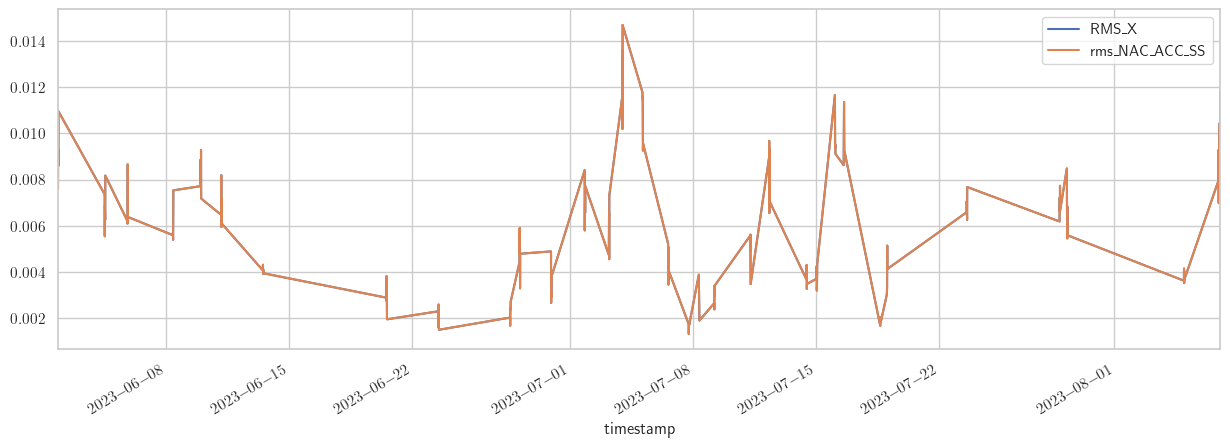

In [60]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# SQL query to merge the required columns from processed_data and scada
query = """
SELECT 
    p.timestamp, 
    p.turbine_name, 
    p.RMS_X, 
    s.rms_NAC_ACC_SS
FROM 
    processed_data p
LEFT JOIN 
    scada s
ON 
    p.timestamp = s.timestamp 
    AND p.turbine_name = s.turbine_name
WHERE 
    p.RMS_X IS NOT NULL 
    AND s.rms_NAC_ACC_SS IS NOT NULL;
"""

# Execute the query and load the result into a pandas DataFrame
merged_data = pd.read_sql_query(query, conn)
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp']).dt.tz_localize(None)
merged_data_C01 = merged_data[merged_data['turbine_name'] == 'NRTC01']
merged_data_C01.query('timestamp > "2023-06-01" and timestamp < "2023-08-10"', inplace=True)
merged_data_C01.plot(x='timestamp', y=['RMS_X', 'rms_NAC_ACC_SS'], figsize=(15, 5))


# synchronization check == > yes

In [61]:
from src.data.utils import get_statistic
from src.utils.rich_utils import print_stats_as_table

import numpy as np
statistics = get_statistic(db_path,['Welch_X', 'Welch_Y', 'Welch_Z', 'RollingAverage_X', 'RollingAverage_Y', 'RollingAverage_Z'],
              [np.max,np.min,np.std,np.mean], 'processed_data',
              timestamp_range=('2023-01-01', '2024-01-01'))
# let's apply a log transformation to the statistics that contain 'Welch' 
for key,item in statistics.items():
    if 'Welch' in key:
        for stat,values in item.items():
            item[stat] = np.log(values)
print_stats_as_table(statistics)



Query: SELECT Welch_X, Welch_Y, Welch_Z, RollingAverage_X, RollingAverage_Y, RollingAverage_Z FROM processed_data WHERE timestamp > '2023-01-01' AND timestamp < '2024-01-01'


                Statistics Table                
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Column Name      ┃ Statistic ┃         Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Welch_X          │ max       │      4.191697 │
│ Welch_X          │ min       │    -18.741716 │
│ Welch_X          │ std       │    -0.9837241 │
│ Welch_X          │ mean      │    -3.8683734 │
│ Welch_Y          │ max       │      4.869997 │
│ Welch_Y          │ min       │    -19.199324 │
│ Welch_Y          │ std       │    -1.4130867 │
│ Welch_Y          │ mean      │     -3.827928 │
│ Welch_Z          │ max       │   -0.17400934 │
│ Welch_Z          │ min       │    -18.453154 │
│ Welch_Z          │ std       │     -5.803719 │
│ Welch_Z          │ mean      │    -7.3886003 │
│ RollingAverage_X │ max       │   0.076331586 │
│ RollingAverage_X │ min       │   -0.07509273 │
│ RollingAverage_X │ std       │   0.006984314 │
│ RollingAverage_X │ mean      │ 6.8863737e-09 │
│ RollingAverage_Y │ max       │    0.09320284 │
│ RollingAverage_Y │ min       │   -0.09582217 │
│ RollingAverage_Y │ std       │  0.0063185487 │
│ RollingAverage_Y │ mean      │  9.452088e-09 │
│ RollingAverage_Z │ max       │    0.01842118 │
│ RollingAverage_Z │ min       │  -0.012660166 │
│ RollingAverage_Z │ std       │ 0.00070675137 │
│ RollingAverage_Z │ mean      │  8.574571e-10 │
└──────────────────┴───────────┴───────────────┘

In [62]:
from src.data.utils import get_statistic
from src.utils.rich_utils import print_stats_as_table

import numpy as np
statistics_scada = get_statistic(db_path,['DEM5_TP_SG_LAT014_Mtn','mean_windspeed'],
              [np.max,np.min,np.std,np.mean], 'scada',
              timestamp_range=('2023-01-01', '2024-01-01'))
# let's apply a log transformation to the statistics that contain 'Welch' 
for key,item in statistics_scada.items():
    if 'Welch' in key:
        for stat,values in item.items():
            item[stat] = np.log(values)
print_stats_as_table(statistics_scada)



Query: SELECT DEM5_TP_SG_LAT014_Mtn, mean_windspeed FROM scada WHERE timestamp > '2023-01-01' AND timestamp < '2024-01-01'


                  Statistics Table                  
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Column Name           ┃ Statistic ┃        Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ DEM5_TP_SG_LAT014_Mtn │ max       │ 5475700.2678 │
│ DEM5_TP_SG_LAT014_Mtn │ min       │  107433.0649 │
│ DEM5_TP_SG_LAT014_Mtn │ std       │  743985.8472 │
│ DEM5_TP_SG_LAT014_Mtn │ mean      │ 1401611.8457 │
│ mean_windspeed        │ max       │      23.4941 │
│ mean_windspeed        │ min       │       0.4712 │
│ mean_windspeed        │ std       │       4.2531 │
│ mean_windspeed        │ mean      │       9.0622 │
└───────────────────────┴───────────┴──────────────┘

In [63]:
statistics_scada['DEM']= statistics_scada['DEM5_TP_SG_LAT014_Mtn']

In [64]:
statistics.update(statistics_scada)

# statistics make sense == > yes

In [65]:
from src.model.prepared_queries import simple_view, do_nothing
columns = ["Welch_X","Welch_Y","Welch_Z"]
transform_func = [nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 15)),LogTransform())]*3
freq_axis_masked = transform_func[0][1].freq_axis_masked
transform_func[0]
key_query  = f"""SELECT id FROM processed_data 
WHERE timestamp BETWEEN '{settings.norther.training_start}' AND '{settings.norther.training_end}'


"""


data_loader = dm.PSDDataModule(
    db_path=db_path,
    view_query=do_nothing, 
    view_table_name='processed_data',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=1024,
    cached=True,
    return_dict=True
)


In [66]:
data_loader.setup()
for b in data_loader.train_dataloader():
    print(b['Welch_X'].shape)
    break

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-em26xpsi'


torch.Size([1024, 492])


In [67]:
# ================================
# Cell: Train the Convolutional AutoEncoder
# ================================
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch
from src.model.backbone.CAE import TrainingConvAE
torch.set_float32_matmul_precision("high")

# 1) Instantiate your convolutional AE training module
model_ae = TrainingConvAE(
    input_spec={'Welch_X': 492, 'Welch_Y': 492, 'Welch_Z': 492},
    # Example encoder/decoder specs:
    encoder_specs=[(3,32,11,2), (32,64,5,2), (64,128,25,3)],
    decoder_specs=[(128,64,15,3), (64,32,5,3), (32,3,3,2)],
    latent_dim=32,
    encoder_activation='leakyrelu',
    decoder_activation='leakyrelu',
    batch_norm=True,
    dropout_rate=0.0,
    debug=False,
    normalization_values=statistics,  # your dict of min/max or mean/std
    lr=1e-3
)

# 2) Define callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="convAE-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min"
)
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min"
)

# 3) Create the Trainer
trainer = Trainer(
    max_epochs=100,
    accelerator='gpu',  # or 'cpu' if you don't have a GPU
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=1,
)

# 4) Fit the model on your DataModule (e.g., `data_loader`)
trainer.fit(model_ae, data_loader)

# 5) Optionally load the best checkpoint after training
best_ckpt_path = checkpoint_callback.best_model_path
model_ae = TrainingConvAE.load_from_checkpoint(best_ckpt_path)

print(f"Best model saved at: {best_ckpt_path}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/damage_prediction_AE/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | loss_fn | MSELoss         | 0      | train
1 | model   | ConvAutoEncoder | 612 K  | train
----------------------------------------------------
612 K     Trainable params
0         Non-trainable params
612 K     Total params
2.451   

Already set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Best model saved at: /home/owilab/Documents/YacineB/Code/damage_prediction_AE/checkpoints/convAE-epoch=97-val_loss=0.72-v1.ckpt


In [68]:
best_ae_path = Path(checkpoint_callback.best_model_path)
model_ae = TrainingConvAE.load_from_checkpoint(best_ae_path)


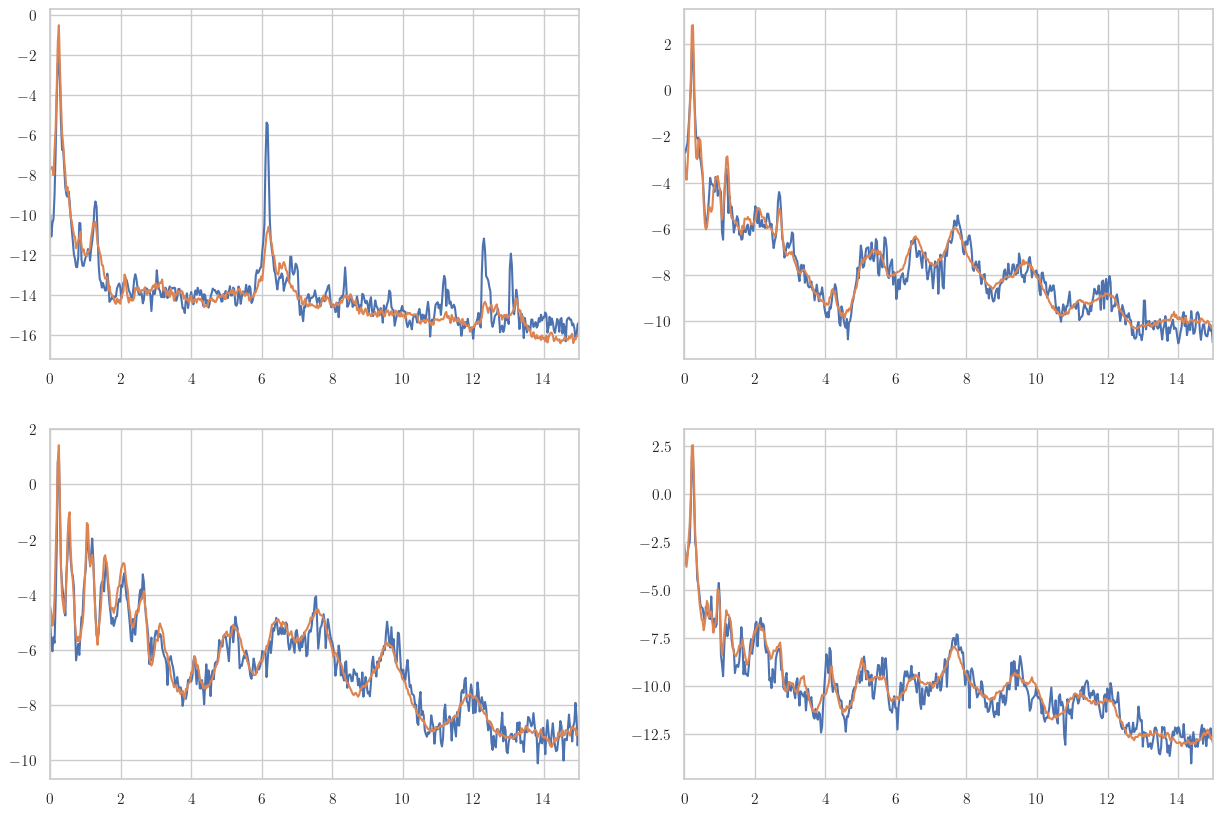

In [69]:
model_ae.to('cpu')
data = next(iter(data_loader.train_dataloader()))

data_rec = model_ae(data) 
welch_x=data['Welch_X']
welch_x_rec = data_rec['reconstruction']['Welch_X']
fig,ax  = plt.subplots(2,2,figsize=(15,10))
for i,(psd_in, psd_out) in enumerate(zip(welch_x[0:4], welch_x_rec[0:4])):
    ax[i//2, i%2].plot(freq_axis_masked, psd_in.cpu().numpy())
    ax[i//2, i%2].plot(freq_axis_masked, psd_out.cpu().detach().numpy())
plt.show()


In [70]:
from src.model.transformation import ToTensor
from src.model.prepared_queries import welch_all_scada_all
columns = ['Welch_X', 'Welch_Y', 'Welch_Z','mean_windspeed','mean_power','mean_pitch','mean_rpm','caseID','turbine_name']
fleet_leaders = list(settings.norther.fleet_leader)
transform_func = 3*[nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 15)),LogTransform())]+4*[ToTensor()]+ 2*[nn.Identity()]
assert len(columns) == len(transform_func)
key_query  = f"""SELECT id FROM dem 
WHERE Turbine_name IN ('{"','".join(fleet_leaders[:5])}')
"""


data_loader_dem = dm.PSDDataModule(
    db_path=db_path,
    view_query=welch_all_scada_all, 
    view_table_name='dem',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=5000,
    cached=True,
    return_dict=True
)


In [71]:
data_loader_dem.setup() 

In [72]:
dfs = []
for batch in data_loader_dem.all_dataloader():
    model_ae.eval()
    # make a dict with only the PSDs
    data_in = {k:batch[k] for k in batch.keys() if 'Welch' in k}
    with torch.no_grad():
        enc = model_ae(data_in)['latent_layer']
    # squeeze the 1 and 2 dimensions
    enc = enc.reshape(enc.shape[0], -1)
        
    df_temp = pd.DataFrame({'mean_windspeed':batch['mean_windspeed'].cpu().numpy(),
                            'mean_power':batch['mean_power'].cpu().numpy(),
                            'mean_pitch':batch['mean_pitch'].cpu().numpy(),
                            'mean_rpm':batch['mean_rpm'].cpu().numpy(),
                            'caseID':batch['caseID'],
                            'embedding':[e.cpu().numpy() for e in enc],
                            'turbine_name':batch['turbine_name']})
    dfs.append(df_temp)
df = pd.concat(dfs)

In [73]:
model_ae(data_in)['latent_layer'].shape

torch.Size([3856, 32, 1])

In [74]:
df['caseID']=df['caseID'].apply(lambda x: x.split(':')[0])
definitions = settings.case_definitions.to_list()
caseid_to_parent_first = {definition['name']: definition['parent_class'][0] for definition in definitions}
caseid_to_parent_first['Missing SCADA'] = "Missing SCADA"
df['ParentCase'] = df['caseID'].map(caseid_to_parent_first)
df['turbine_name'].unique()


array(['NRTC01', 'NRTC03', 'NRTF03', 'NRTH01', 'NRTJ03'], dtype=object)

In [75]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import umap
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
sns.set(style="whitegrid")



# 2. Combine all embeddings into a numpy array for turbine_name == 28

# Ensure that 'embedding' column contains iterable sequences (e.g., lists or arrays)
# Replace the following line with actual embeddings extraction
# embeddings = np.vstack(df_turb['embedding'].apply(np.array).values)
embeddings = np.vstack(df['embedding'].values)

# Apply t-SNE or UMAP for dimensionality reduction if needed
# Uncomment and use one of the following as per your requirement

# Example using t-SNE:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Example using UMAP:
#umap_reducer = umap.UMAP(n_components=2, random_state=42)
#embeddings_2d = umap_reducer.fit_transform(embeddings)

# For demonstration, let's assume embeddings_2d is already 2D
# Replace this with actual dimensionality reduction if applied
#embeddings_2d = embeddings  # Replace with actual reduced embeddings

In [76]:
df_embendings = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df.reset_index(drop=True, inplace=True)
df = pd.concat([df, df_embendings], axis=1)


/tmp/ipykernel_2369673/3617728020.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


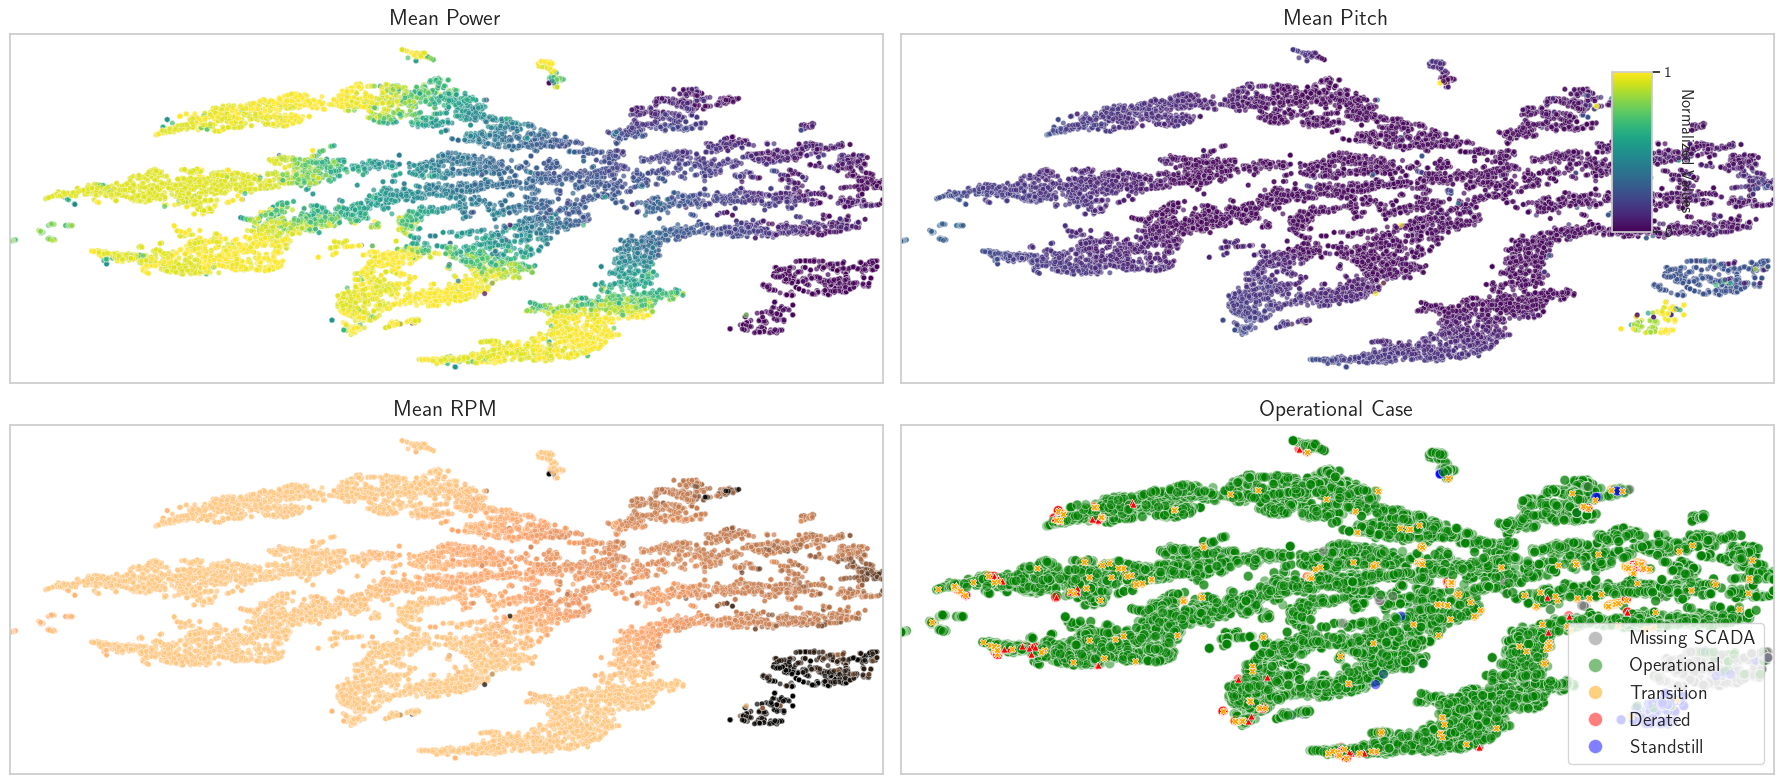

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Extract embeddings for dimensionality reduction

df_turb = df
# Begin plotting
sns.set(style="whitegrid")
fig, ax = plt.subplots(2, 2, figsize=(20, 8))

# Mean Power plot
sc1 = sns.scatterplot(
    data=df_turb,
    x='x',
    y='y',
    hue='mean_power',
    palette="viridis",
    ax=ax[0, 0],
    legend=False,
    s=15,
    alpha=0.7)

ax[0, 0].set_title("Mean Power",fontsize=16)

# Mean Pitch plot
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
sns.scatterplot(
    data=df_turb,
    x='x',
    y='y',
    hue='mean_pitch',
    palette="viridis",
    ax=ax[0, 1],
    legend=False,
    s=15,
    alpha=0.7
)
ax[0, 1].set_title("Mean Pitch",fontsize=16)


# Add a colorbar for Mean Pitch
cbar_ax = fig.add_axes([0.81, 0.7, 0.02, 0.2])  # Adjust position and size of the colorbar
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label("Normalized Values", rotation=270, labelpad=15)
cbar.set_ticks([0, 1])
cbar.ax.set_yticklabels(['0', '1'])

# Mean RPM plot
sns.scatterplot(
    data=df_turb,
    x='x',
    y='y',
    hue='mean_rpm',
    palette="copper",
    ax=ax[1, 0],
    legend=False,
    s=15,
    alpha=0.7
)
ax[1, 0].set_title("Mean RPM",fontsize=16)


# ParentCase plot
custom_palette = {
    "Missing SCADA": "grey",
    "Operational": "green",
    "Transition": "orange",
    "Derated": "red",
    "Standstill": "blue",
}

sns.scatterplot(data=df_turb,
    x='x',
    y='y',
    hue='ParentCase',
    palette=custom_palette,
    ax=ax[1, 1],
    s=50,
    alpha=0.5
)
# plot derated points with a different marker 
df_derated = df_turb[df_turb['ParentCase'] == 'Derated']
sns.scatterplot(data=df_derated,
    x='x',
    y='y',
    color='red',
    marker='^',
    s=25,
    ax=ax[1, 1],
    label='Derated'
)
df_transition = df_turb[df_turb['ParentCase'] == 'Transition']
sns.scatterplot(data=df_transition,
    x='x',
    y='y',
    color='orange',
    marker='X',
    s=25,
    ax=ax[1, 1],
    label='Transition'
)
# remove the legend for the derated points
handles, labels = ax[1, 1].get_legend_handles_labels()
# remove redundant labels
for i in range(len(labels)):
    # if the label is already in the handles, remove it
    if labels[i] in labels[:i]:
        labels[i] = ""
# remove the empty labels
labels = [label for label in labels if label != ""]
# remove the empty handles
handles = [handle for handle, label in zip(handles, labels) if label != ""]
#increase the size of the legend markers
for handle in handles:
    handle.set_markersize(10.0)
ax[1, 1].legend(handles=handles, labels=labels, loc='lower right',fontsize=14)    

ax[1, 1].set_title("Operational Case",fontsize=16)
ax[1, 1].set_xlabel("embedding (dimension 1)")
for i in range(4):
    # remove the x shadow of the colossusand y axis labels and ticks 
    ax[i//2, i%2].set_ylabel("")
    ax[i//2, i%2].set_xlabel("")
    ax[i//2, i%2].set_xticks([])
    ax[i//2, i%2].set_yticks([])
    


plt.tight_layout(rect=[0, 0, 0.9, 1])
# save the figure

#plt.savefig('embedding_plot.png', dpi=300)
plt.show()

In [78]:
from src.model.transformation import ToTensor
from src.model.prepared_queries import welch_all_scada_all, welch_all_scada_wo_dem
columns = ['Welch_X','Welch_Y','Welch_Z','mean_windspeed','mean_power','mean_pitch','mean_rpm','caseID','turbine_name','timestamp','DEM']
fleet_leaders = list(settings.norther.fleet_leader)
transform_func = 3*[nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 15)),LogTransform())]+4*[ToTensor()]+ 4*[nn.Identity()]
assert len(columns) == len(transform_func)
key_query  = f"""SELECT id FROM dem"""


data_loader_dem = dm.PSDDataModule(
    db_path=db_path,
    view_query=welch_all_scada_all, 
    view_table_name='dem',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=4096,
    cached=True,
    return_dict=True
)
data_loader_dem.setup() 

In [79]:
dfs = []
for batch in data_loader_dem.train_dataloader():
    with torch.no_grad():
        data = model_ae(batch)
    df_temp = pd.DataFrame({'embedding' : [e.flatten() for e in data['latent_layer'].cpu().numpy()],
                            'turbine_name': batch['turbine_name'],
                            'timestamp': batch['timestamp'],
                            'DEM': batch['DEM'].cpu().numpy()})
    dfs.append(df_temp)


In [80]:
df_emb_dem = pd.concat(dfs)

In [81]:
# train a random forest on the embedding to predict the DEM using only the 2 first turbines
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df_emb_dem_train = df_emb_dem.query(f'turbine_name in {fleet_leaders[:2]}')
X = np.stack(df_emb_dem_train['embedding'].values)
y = df_emb_dem_train['DEM'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_squared_error(y_test, y_pred)


np.float64(101371939076.30185)

In [82]:
df_emb_dem['pred_dem'] = rf.predict(np.stack(df_emb_dem['embedding'].values))

In [83]:
df_emb_dem['timestamp']= pd.to_datetime(df_emb_dem['timestamp'])
df_emb_dem.sort_values('timestamp', inplace=True)

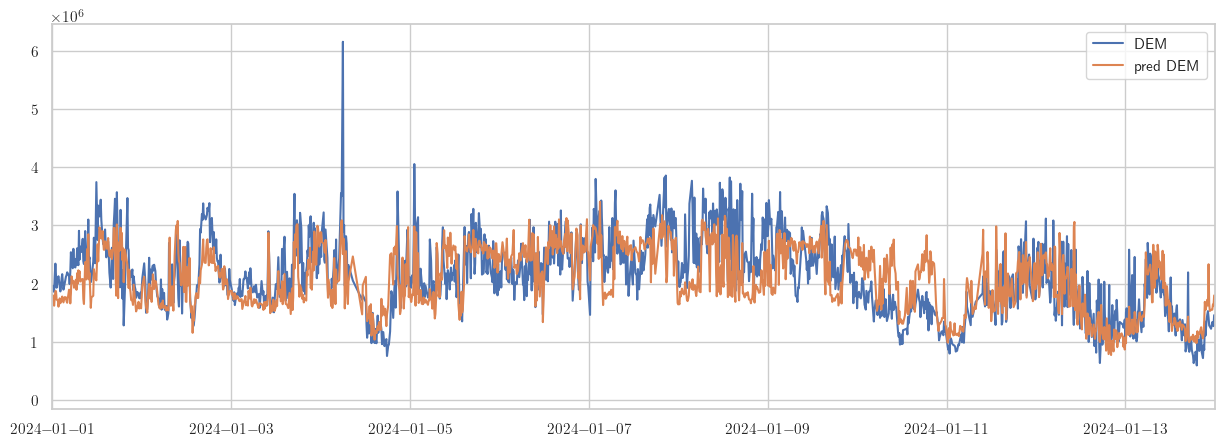

In [84]:
df_emb_dem_turb = df_emb_dem[df_emb_dem['turbine_name']=='NRTH01']
fig,ax= plt.subplots(1,1,figsize=(15,5))
start_time = pd.to_datetime('2024-01-01')
end_time = pd.to_datetime('2024-01-14')
ax.plot(df_emb_dem_turb['timestamp'], df_emb_dem_turb['DEM'], label='DEM')
ax.plot(df_emb_dem_turb['timestamp'], df_emb_dem_turb['pred_dem'], label='pred DEM')
ax.set_xlim(start_time, end_time)
ax.legend()
plt.show()

In [86]:
from src.evaluation.metric import r2_score, relative_err

df_emb_dem.groupby('turbine_name').apply(lambda x: relative_err(x['DEM'], x['pred_dem']))

/tmp/ipykernel_2369673/1487434706.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_emb_dem.groupby('turbine_name').apply(lambda x: relative_err(x['DEM'], x['pred_dem']))


turbine_name
NRTC01    0.065721
NRTC03    0.070951
NRTF03    0.223050
NRTH01    0.209146
NRTJ03    0.191359
dtype: float64